# An Simple Data Analysis Example Project

<p>
    <i>The purpose of this document is to show potential recruiters basic abilities in data analysis and visualization with python: pandas, sklearn, matplotlib and alike.</i></p>
    <p><i>I will use real world data from Eurostat, which is loaded and cleaned in the <a href="#Production-in-construction---quarterly-data,-2010--2017">first chapter</a>. After giving a short outline of the gathered data, I will try to compare <a href="#Basic-Descreption">different parts of europe</a> by using another a json dataset for categorization. The <a>following section</a> shows an advanced violinplot which typical and untypical members for each part of Europe. Afterward I will compare construction index data and unemployment rate <a href="#Correlations-of-unemploymentrate-and-construction">explanation</a>, and see if there is always a negative correlation</i></p>

## Load Libraries and configuration

In [1]:
from IPython.display import HTML, display #disposable
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
import myCodeDepository #Some code seems a little boring in this notebook

In [2]:
%matplotlib inline

In [3]:
figure_width = 30 # in cm
figure_width *= 0.393701 # in inch

#### Production in construction - quarterly data, 2010 -2017
<a href='https://data.europa.eu/euodp/de/data/dataset/cU0o0f7w4AWkggvNgntg' target='_blank'>https://data.europa.eu/euodp/de/data/dataset/cU0o0f7w4AWkggvNgntg</a>

<p>We will retrieve the data from Eurostat by using the pandas_datareader.data module <span style="color:green; font-family: monospace;">as</span> web</p>

In [4]:
contributor = 'eurostat'
dataID = 'sts_copr_q'
data = web.DataReader(dataID, contributor)

<p>Sorting the data, makes it just a little faster and easier to work with:</p>

In [5]:
data.sort_index(axis=1, inplace=True)

## Basic Description

### Basic shape, index, MultiIndex levels

<p>There are some build in pandas tools, which give a fast and easy insight to a <code>DataFrame</code>, like <code>DataFrame.info()</code>:

In [6]:
data.info(memory_usage=False)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2010-01-01 to 2017-04-01
Freq: QS-OCT
Columns: 999 entries, (Index, 2010=100, Volume index of production, Calendar adjusted data, not seasonally adjusted data, Buildings, Austria, Quarterly) to (Percentage change on previous period, Volume index of production, Unadjusted data (i.e. neither seasonally adjusted nor calendar adjusted data), Construction, United Kingdom, Quarterly)
dtypes: float64(999)

<p><code>dataframe.get_ftype_counts()</code> shows that we have dense data and only <code>int64</code> data types and quite a lot of columns:</p>

In [7]:
data.get_ftype_counts()

float64:dense    999
dtype: int64

<p>Since there are so many levels and columns I have written my own description code of <code>MultiIndex</code>, which output is shown below</p>

In [8]:
MultiIndexInfo = myCodeDepository.describeMultiIndex(data)
display(HTML(MultiIndexInfo.render()))

As we can see some of the MultiIndex levels are not really used – they just contain one column. Let's get rid of them:

In [9]:
data.columns = data.columns.droplevel('INDIC_BT')
data.columns = data.columns.droplevel('FREQ')

With that many columns to build in describe function gets a little tedious, so I only use it on the mean of 'S_ADJ' level – the type of seasonally adjustment.

In [10]:
data['Index, 2010=100'].groupby(axis=1, level='NACE_R2').mean().describe()

NACE_R2,Buildings,Civil engineering works,Construction
count,30.000000,30.000000,30.000000
mean,107.092340,104.372807,104.320102
std,10.771883,14.123907,10.473389
min,88.070000,77.252222,84.973148
25%,100.721389,97.285833,98.710648
50%,106.493333,104.646111,104.443981
75%,113.913937,113.829444,109.758796
max,126.411111,128.596667,123.490741


#### Basic Information about Countries: Currency, Region ...
https://restcountries.eu/

In [11]:
dataID = 'countryInfo'
countryInfo = pd.read_json('https://restcountries.eu/rest/v2/region/europe')

In [12]:
countryInfo.sort_index(axis=1, inplace=True)

<p>Now let's see if the country chosen country names are identical</p>
<p>Country names from Eurostat that are not (<code>~</code>) in the restcountries set (<code>format()</code> is just for readability):</p>

In [13]:
data.columns.levels[3][~data.columns.levels[3].isin(countryInfo.name)].format()

['Euro area (19 countries)',
 'European Union (28 countries)',
 'Former Yugoslav Republic of Macedonia, the',
 'Germany (until 1990 former territory of the FRG)',
 'Turkey',
 'United Kingdom']

and countries in the restcountries set, that are not in the eurostat data:

In [14]:
countryInfo.name[~countryInfo.name.isin(data.columns.levels[3])].values

array(['Åland Islands', 'Albania', 'Andorra', 'Belarus', 'Faroe Islands',
       'Germany', 'Gibraltar', 'Guernsey', 'Holy See', 'Iceland',
       'Isle of Man', 'Jersey', 'Liechtenstein',
       'Macedonia (the former Yugoslav Republic of)',
       'Moldova (Republic of)', 'Monaco', 'Republic of Kosovo',
       'Russian Federation', 'San Marino', 'Svalbard and Jan Mayen',
       'Ukraine', 'United Kingdom of Great Britain and Northern Ireland'], dtype=object)

<p>Sometimes Eurostat uses quite long and exhaustive names for countries like 'Germany (until 1990 former territory of the FRG)'. We'll replace them with short names. Also, they offer meta-values like 'European Union (28 countries)', which we won't need.</p>
<p>Throwing Turkey out of Europe is not a political statement. It just not handled by my other data sources as Europe so it does not make much sense to keep it in the data.</p>

In [15]:
columnsRenameEurostat = {'Germany (until 1990 former territory of the FRG)':'Germany','Former Yugoslav Republic of Macedonia, the': 'Macedonia'}
dropEuroStat = ['Euro area (18 countries)','Euro area (19 countries)', 'European Union (28 countries)', 'Euro area (19 countries)', 'European Union (27 countries)', 'European Union (28 countries)','European Union (27 countries)','Euro area (18 countries)', 'Euro area (27 countries)', 'Euro area (19 countries)','European Union (28 countries)', 'Turkey']

In [16]:
data.rename(columns=columnsRenameEurostat, inplace = True)
data.drop( dropEuroStat, level=3, axis=1, inplace=True)

And with the restcountries we will replace these names as well:

In [17]:
columnsRenameRestcountries = {'name':{'Macedonia (the former Yugoslav Republic of)': 'Macedonia', 'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom'}}
dropRestcountries = ['Åland Islands', 'Albania', 'Andorra', 'Belarus', 'Faroe Islands', 'Gibraltar', 'Guernsey', 'Holy See', 'Iceland', 'Isle of Man', 'Jersey', 'Liechtenstein', 'Moldova (Republic of)', 'Monaco', 'Republic of Kosovo', 'Russian Federation', 'San Marino', 'Svalbard and Jan Mayen', 'Ukraine']

In [18]:
countryInfo.replace(columnsRenameRestcountries, inplace = True)
countryInfo = countryInfo[~countryInfo.name.isin(dropRestcountries)]

## Compare European Regions and branches

We are going to compare the four main parts of Europe by NACE_R2

For this we will need adjusted index data,

In [19]:
adjustedData = data['Index, 2010=100', 'Seasonally and calendar adjusted data']

a list of the main European regions available in the data,

In [20]:
europeRegions = countryInfo['subregion'].unique()
europeRegions = {europeRegion: countryInfo.loc[countryInfo['subregion']==europeRegion,['name']].values.flatten() for europeRegion in europeRegions}

the names of the branches (as iterator object),

In [21]:
NACE_R2 = adjustedData.columns.levels[adjustedData.columns.name=='NACE_R2']
NACE_R2 = np.nditer(NACE_R2,['refs_ok'])

and a mean of the branches:

In [22]:
meanAdjustedData = adjustedData.groupby(axis=1, level='GEO').mean()

Now will draw a figure with four subplots and shared axes for visual data comparison

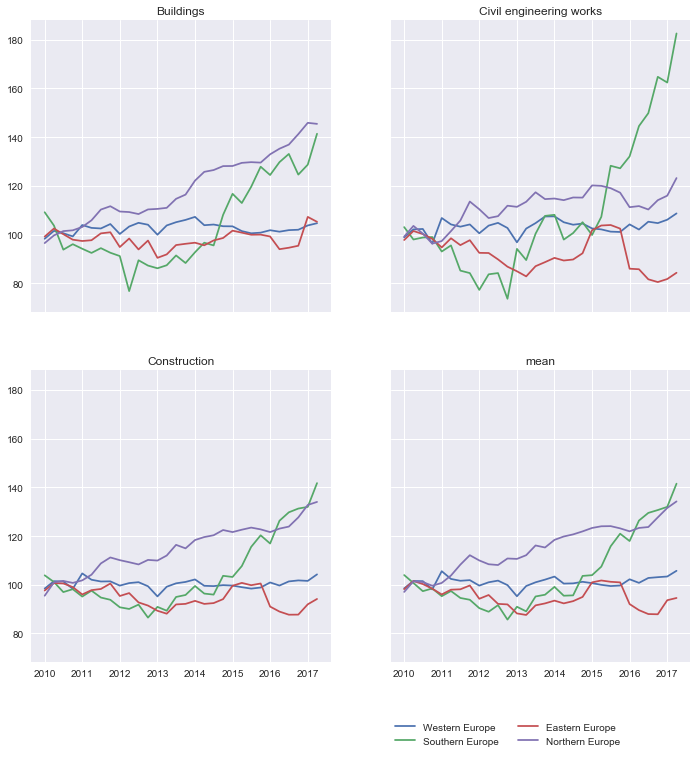

In [23]:
#Using a predefined style
matplotlib.style.use('seaborn-darkgrid')


#Drawing the main figure, with 2*2 suplots
#These subplots should share x and y axes, so we can compare the values between them properly
meanFigure, axes = plt.subplots(2,2, sharex=True, sharey=True, figsize=(figure_width, figure_width))

#The first three axes are for the NACE_R2 data, the fourth is for the mean
NACR_R2_axes = axes.flatten()[:-1]
mean_ax = axes[1][1]


#Iter through each subplot to fill it with the NACE_R2 data
for ax in NACR_R2_axes:
    #Set title
    business_type = next(NACE_R2)
    business_type = business_type.item() #We will need a string instead of a numpy array
    ax.set_title(business_type)
    
    #Get data for NACE_R2
    business_data = adjustedData[business_type]
    
    #Draw data for every region
    for europeRegion, countries in europeRegions.items():
        
        #Filter for countries that are not in both tables
        countries = np.intersect1d(countries, business_data.columns.values)
        
        #Get the data for countries
        regional_data = business_data[countries].mean(axis=1)
        
        #Plot it and give it a label
        ax.plot(regional_data, label=europeRegion)
        
#Draw the mean data
mean_ax.set_title('mean')

# ... for every region 
for europeRegion, countries in europeRegions.items():
    
    #Filter for countries that are not in both tables
    countries = np.intersect1d(countries, meanAdjustedData.columns.values)
    
    #Get the data for countries
    regional_data = meanAdjustedData[countries].mean(axis=1)
    
    #Plot it and give it a label
    mean_ax.plot(regional_data, label=europeRegion)
    
#Draw a legend
mean_ax.legend(loc=(0,-0.3),ncol=2)

NACE_R2.reset() #clean up ;-)

You may wonder what's up with Southern Europe. I'll show it with a table:

In [24]:
#Select mean data of southern Europe
sEuropeMean = meanAdjustedData[europeRegions['Southern Europe']]

#Resample the data to anual (quarterly is quite long)
sEuropeMean = sEuropeMean.resample('A').mean()

#Sort the values by the last year
sEuropeMean.sort_values(axis=1, by=sEuropeMean.index[-1], ascending=False, inplace=True)

#Show the data with a green heatmap
sEuropeMean.style.background_gradient(
    cmap=sns.light_palette('green', as_cmap=True)
    )

GEO,Montenegro,Macedonia,Malta,Serbia,Spain,Bosnia and Herzegovina,Croatia,Italy,Slovenia,Cyprus,Portugal,Greece
TIME_PERIOD,,,,,,,,,,,,
2010-12-31 00:00:00,100.4,98.1083,100,100.3,99.8917,101.3,99.8333,99.05,101.142,99.9917,100.008,101.4
2011-12-31 00:00:00,122.442,127.625,104.5,116.625,78.4,95.475,88.625,95,74.3667,93.225,87.25,59.6667
2012-12-31 00:00:00,129.592,138.467,106.275,122.125,73.3333,91.9,77.775,82.275,61.625,73.4,73.0917,39.7583
2013-12-31 00:00:00,182.583,196.942,108.25,95.425,74.5,90.95,74.375,73.925,57.7583,61.2917,61.2583,35.925
2014-12-31 00:00:00,246.217,192.108,110.9,98.5,84.1583,96.2,68.925,68.975,69.975,49.0167,55.2833,41.2667
2015-12-31 00:00:00,300.7,273.75,128.5,116.75,87.2917,93.85,68.2583,67.7,64.7833,46.075,53.525,43.1083
2016-12-31 00:00:00,434.117,297.658,123.625,127.175,92.775,92.25,69.7667,67.625,53.1,51.6583,51.4667,52.1917
2017-12-31 00:00:00,554.667,235.667,137.15,124.85,94.0667,91.15,70.7667,67.25,61,60.4,52.5333,50.9


So, it is quite easy to see: While Montenegro has grown five times it original state, and Macedonia 2.35 all other countries are only between +37% and -50%

<p>Also, there is an interesting peak in Eastern Europe in Construction and in Eastern & Northern Europe in civil engineering work from 2015/4 to 2016/4. Let's look at that:</p>

We will put the data of interest into three distinct DataFrames:

In [25]:
easternEuropeConstruction = adjustedData['Construction'].loc['2014':'2016', europeRegions['Eastern Europe']]
easternEuropeCivil = adjustedData['Civil engineering works'].loc['2014':'2016', europeRegions['Eastern Europe']]
northernEuropeCivil = adjustedData['Civil engineering works'].loc['2014':'2016', europeRegions['Northern Europe']]

and combine them in a dataframe for iteration:

In [26]:
correlationDF = pd.DataFrame({'dfs': [easternEuropeConstruction, easternEuropeCivil, northernEuropeCivil]}, columns=['dfs'])
correlationDF.index = ['Eastern Europe Construction', 'Eastern Europe Civil', 'Northern Europe Civil' ]

Now we would like to find out how similar the lines for each of the countries is to the line above in the Eastern European civil engineering work plot.

We will put a dummy series for each data holding DataFrame, that will hold the country names as index to put the correlation coefficient numbers in:

In [27]:
correlationDF['r'] = [pd.Series(index=df.columns) for df in correlationDF['dfs']]

Now we will calculate it:

In [28]:
mean_timeline = easternEuropeCivil.mean(axis=1)
for _, row in correlationDF.iterrows():
    data_of_interest = row['dfs']
    target = row['r']
    for country, series in data_of_interest.iteritems():
        target[country], _ = stats.pearsonr(series, mean_timeline)

Now let's visualize the data: We will highlight all countries with East European countries with a Pearson correlation coefficient over 0.8 and all Northern European countries with r over 0.6 to the mean of Eastern Europe civil engineering work. Of Corse this are arbitrary limits, we choose. We set the limit for Northern Europe lower, because there is simply less correlation.

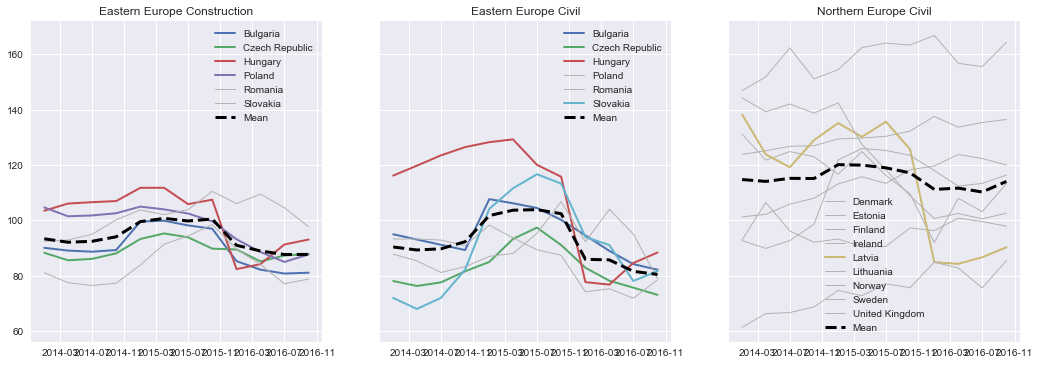

In [29]:
#The main figure with 3 subplots in a row
meanFigure, axes = plt.subplots(1,3, sharex=True, sharey=True, figsize=(figure_width*1.5, figure_width/2))

#Countries with r bigger than corr_limit will be highlighted
corr_limit = iter([0.7, 0.7, 0.6])
#others will be ...
grey = '0.7'

#We will go row by row
rows = correlationDF.iterrows()

#and subplot (ax) by subplot
for ax in axes:
    #Get area (region & NACE_R2), data (row) and the correlation limit
    area, row = next(rows)
    current_corr_limit = next(corr_limit)
    
    #Set title
    ax.set_title(area)
    
    #Get data and correlations
    data_of_interest = row['dfs']
    correlation = row['r']
    
    #Plot each country
    for country, series in data_of_interest.iteritems():
        #Check in correlation series if highlight
        highlight = correlation[country] > current_corr_limit
        
        #Plot
        lines = ax.plot(series, label=country)
        #Get the drawn line (lines is here a list of len 0)
        line = lines[0]
        
        if highlight:
            #Color is choosen automaticaly
            line.set_linewidth(2.0)
        else:
            #if not highlighted, make it thinner and grey
            line.set_linewidth(1.0)
            line.set_color(grey)

    #Additionally, we we'll draw the mean line from above
    mean_lines = ax.plot(data_of_interest.mean(axis=1), label='Mean')
    
    #and set it thick, black and dashed
    mean_lines = mean_lines[0]
    mean_lines.set_linewidth(3)
    mean_lines.set_color('black')
    mean_lines.set_linestyle('--')
    
    #And draw a legend
    ax.legend()

Where will see that in Eastern Europe Bulgaria, Hungary, the Czech Republic and Poland/Slovakia behave like the mean, while in Northern Europe Latvia tends to behave like an Eastern European country.

Let's have a quick look at the correlation matrix between them all:

In [30]:
# Put all in a single DataFrame
concatenated = pd.concat(correlationDF.dfs.values, axis=1, keys=correlationDF.index)
#and calculate the correlation:
correlationMatrix = concatenated.corr()

With classical pandas DataFrame printing, this is a little hard to see, so we will do some high lightening and crop the DataFrame a little:

In [31]:
cm = sns.diverging_palette(250,50, as_cmap=True)
correlationMatrix.loc[['Northern Europe Civil', 'Eastern Europe Civil'], ['Eastern Europe Construction']].\
    style.format("{:.2}").\
    background_gradient(cmap=cm)

Which shows a lot of positive correlations between east European countries and negative correlations between east and north European countries.

But there are some exceptions too:

So, Denmark, Finland, Norway, Sweden and the United Kingdom show quite strong correlation to Romania, which does not correlate positive to Hungary and Poland. On the other hand, Latvia, Lithuania and Estonia do have quite strong correlations to Hungary and Poland.

## Violin plot for each region in 2 year steps

Now try something a little more advanced, a violin plot:

In [32]:
#style again
matplotlib.style.use('seaborn-whitegrid')

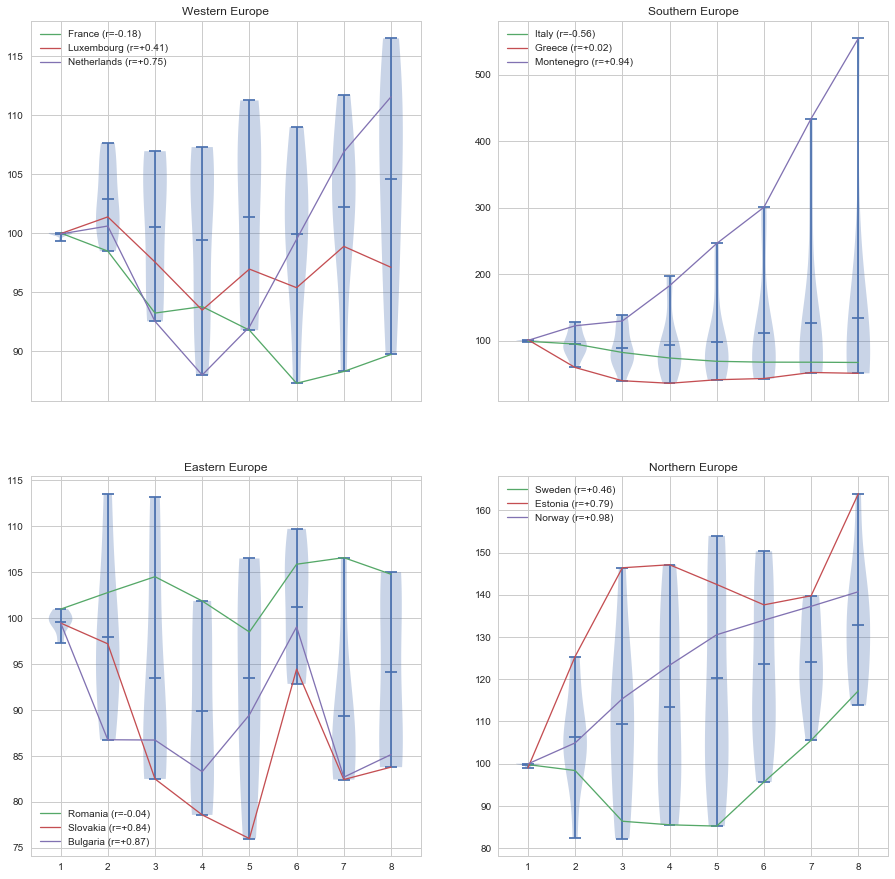

In [33]:
#A figure with 2 * subplots, that share x but not y, since with different scales it is easier to see the single lines
violin, plots = plt.subplots(2,2,sharex=True, figsize=(figure_width * 1.3, figure_width * 1.3))

#make an iterable of Europe regions:
iterEuropeRegions = iter(europeRegions.items())

#We will sample the mean of the adjusted data annually down
meanAdjustedDataASample = meanAdjustedData.resample('A').mean()

#Positions of the legend (since automatic does not work)
legend_position = iter([2, 2, 3, 2])

#clip data at:
treshold = 160

for p in plots.flatten():
    
    #Get name and country names of region
    region, countries = next(iterEuropeRegions)

    #set title
    p.set_title(region)
    
    #Get data:
    draw_data = meanAdjustedDataASample[countries]
    
    #Plot (the clipped transformation) with means and extrema
    violin = p.violinplot(draw_data.T.values,
                          showmeans=True, showextrema=True)
    
    # Find interesting countries to show as examples
    # Compute for each the correlation to thee mean, assuming that the max correlation representing a typical
    # represantative of the group, the min and median corr "spikes" of the group, and therefore
    # "interesting"
    
    # Calculating the correlation to the mean of each region for each country
    correlationToTheMean = draw_data.corrwith(draw_data.mean(axis=1))
    #sorting
    correlationToTheMean.sort_values(inplace=True)
    #Finding the first, the last and the one in the middle ...
    interestingCountries = correlationToTheMean.T[[0,
                                                    correlationToTheMean.index.size//2,
                                                    correlationToTheMean.index.size-1]]

    for country, corr in interestingCountries.items():
        countrySeries = draw_data[country]
        countrySeries = np.append([np.nan], countrySeries.values)
        country_ab = country.split(' ')[0]
        label = country_ab + ' (r={0:+.2f})'.format(corr)
        p.plot(countrySeries, label=label, lw=1.3)

    legend = p.legend(loc=next(legend_position))


#### Compare unemployment rate and construction index for Europe's x biggest Countries

We will draw a plot the compares unemployment rate and construction index: 

In [34]:
#We will choose the six biggest countries:
bcLen=4
#Sort countries by population
bigCountries = countryInfo.sort_values('population', ascending=False)
#Only get the six biggst ones
bigCountries = bigCountries[:bcLen]
#Only get their names and make an iterator
bigCountries = bigCountries['name'].values

In [35]:
display(HTML('<h2>Compare unemployment rate and construction index for Europe\'s {0} biggest Countries</h2>'.format(bcLen)))

We will have to get the unemployment rate, which is provided by Eurostat:

In [36]:
#Unemployment rate
dataID = 'tsdec450'
unemploymentRate = web.DataReader(dataID, contributor)

In [37]:
multiIndexInfo = myCodeDepository.describeMultiIndex(unemploymentRate)
display(HTML(multiIndexInfo.render()))

In [38]:
#Clean Up
unemploymentRate.columns = unemploymentRate.columns.droplevel(['AGE', 'SEX', 'FREQ'])
unemploymentRate.rename(columns=columnsRenameEurostat, inplace = True)
unemploymentRate.drop(dropEuroStat, level='GEO', axis=1 , inplace=True)
unemploymentRate.dropna(axis=1, inplace=True, how='all')

In [39]:
#Sort
unemploymentRate.sort_index(axis=1, inplace=True)

Then we downsample the unemployment rate (Percentage of active population)

In [40]:
unemploymentRateASample = unemploymentRate['Percentage of active population'].resample('A').mean()

Now we are going to draw two plots at the same time, unemployment and construction:

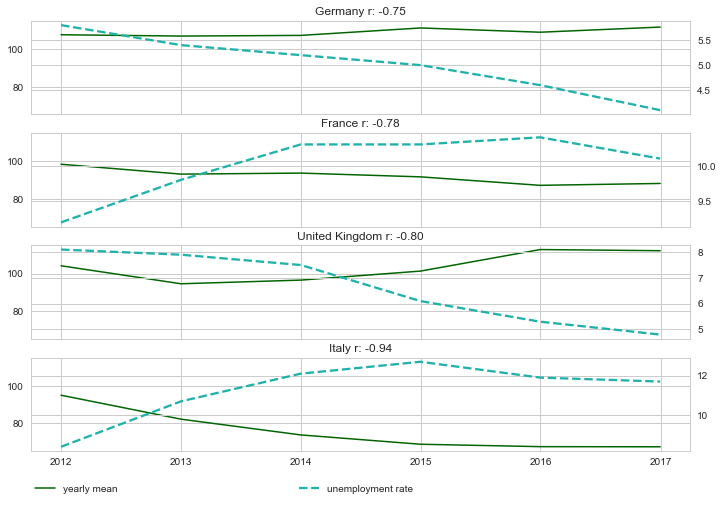

In [41]:
bigCountriesFigure, plots = plt.subplots(bcLen,1, sharex=True, sharey=True, figsize=(figure_width, figure_width * 0.67))

#make iterable of plots / countries
plots = plots.flatten()
drawData = tuple(zip(plots, bigCountries))

#counter
c = 1
#draw data
for p, country in drawData:
    
    #get construction data
    cMean = meanAdjustedDataASample.loc['2011':'2016',country]
    #get unemployment data (and resample it)
    cUR = unemploymentRateASample.loc['2011':'2016',country]
    #plot it
    p.plot(cMean, label = 'yearly mean', color='darkgreen', linewidth=1.5)
    #plot a twin: different data with different y at same x and plot
    p2 = p.twinx()
    p2.plot(cUR, linestyle='--', label = 'unemployment rate', color='lightseagreen', linewidth=2.3)
    
    #if drawn all plots, draw two legends
    if c == bcLen:
        legend1 = p.legend(loc=(0,-0.5))
        legend2 = p2.legend(loc=(0.4, -0.5))
    # set title with correlation construction index/unemployment rate
    p.set_title('{0} r: {1:+.2f}'.format(country, round(cUR.corr(cMean),2)))

    c += 1

## Correlations of unemployment rate and construction
<p>If you compare  unemployment rates and construction indices, you would expect negative correlation. Let's take a look at it</p>

In [42]:
#We just look at countries where we have both data
countries = unemploymentRateASample.columns.intersection( meanAdjustedDataASample.columns)
#Now we calculate the correlation for each country
pearCorr = pd.DataFrame([stats.pearsonr( meanAdjustedDataASample.loc['2011':'2016',country], 
                                         unemploymentRateASample.loc['2011':'2016',country])
                         for country in countries],
                         index = countries,
                         columns = ['r', 'p'])

In [43]:
pearCorr.sort_values(by='r', inplace=True)
pearCorr.dropna(inplace=True)
pearCorr = pearCorr[pearCorr['p']>=0.05]# and where the correlation is 'significant'

How many countries have a correlation <-0.3, >= -0.3 and <= 0.3, and > 0.3?

In [44]:
s = pearCorr.r[pearCorr.r < -0.3].shape[0]
m = pearCorr.r[(-0.3 <= pearCorr.r) & (pearCorr.r <= 0.3)].shape[0]
b = pearCorr.r[pearCorr.r > 0.3].shape[0]

In [45]:
print(s, 'countries are below -0.3')
print(m, 'countries are between -0.3 and +0.3')
print(b, 'countries are over +0.3')

13 countries are below -0.3
5 countries are between -0.3 and +0.3
4 countries are over +0.3


Now we will plot the whole thing:

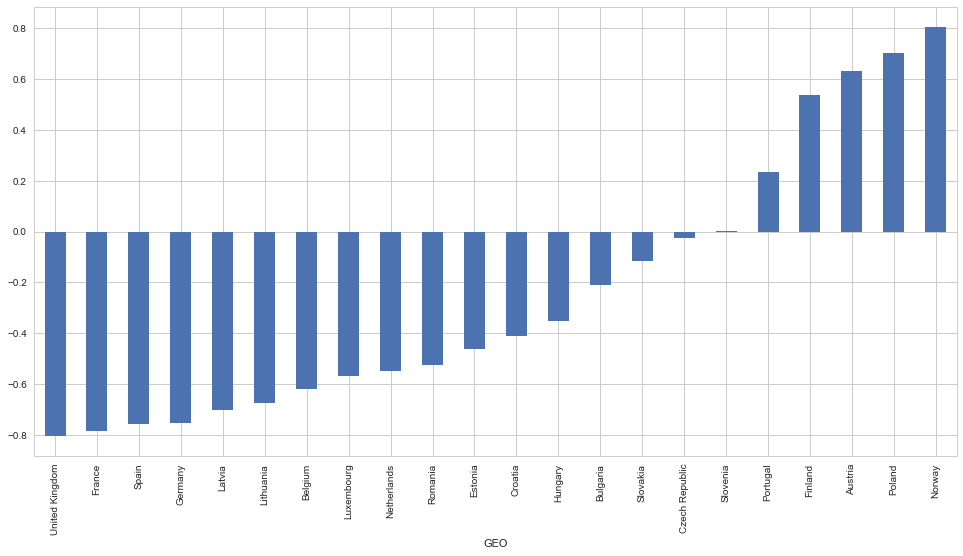

In [46]:
pearCorr['r'].plot(kind='bar', figsize=(figure_width*1.4, figure_width*0.7))